# Double Jet

With various grid sizes

In [19]:
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.style.use('dark_background')

plt.rcParams["image.origin"] = "lower"


In [20]:
%cuda_context_handler gpu_ctx

In [21]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.DoubleJetPlot import *

Get initial arguments from class

In [22]:
from gpuocean.utils import DoubleJetCase

In [23]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## Experiment

In [24]:
MLMCsource_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/MLMC/2023-10-27T14_52_13"

In [25]:
Ts = np.load(source_path+"/MLts.npy")

In [30]:
MLMCrmse = np.load(source_path+"/MLrmses.npy")
MLMCstd = np.load(source_path+"/MLstddevs.npy")

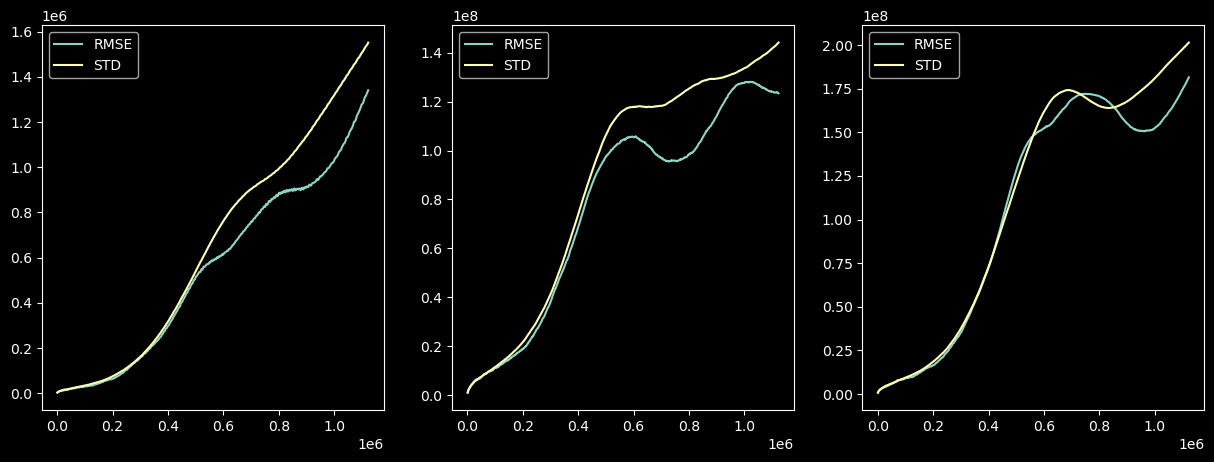

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    axs[i].plot(Ts, MLMCrmse[:,i], label="RMSE")
    axs[i].plot(Ts, MLMCstd[:,i], label="STD")
    axs[i].legend()

In [33]:
MLMCscores = np.load(source_path+"/MLscores.npy")
MLMCdiff_scores = np.load(source_path+"/MLdiff_scores.npy")

In [35]:
MLMCscores[0]

array([[1.88424485e-04, 2.41559575e+06, 1.81059975e+06],
       [1.44448059e-04, 2.92541775e+06, 1.29850650e+06],
       [1.50376509e-04, 2.90381850e+06, 1.25975625e+06]])

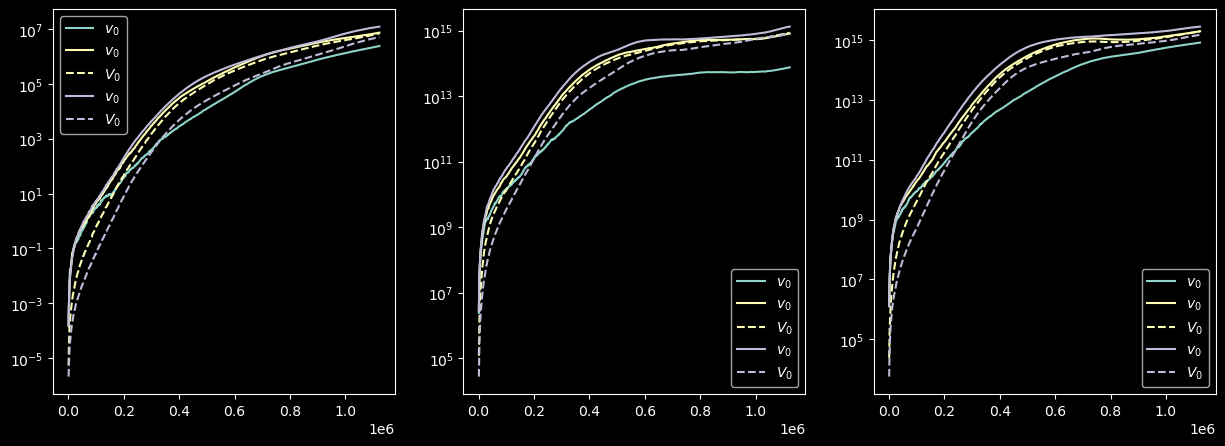

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    for l_idx in range(3):
        axs[i].plot(Ts, MLMCscores[:,l_idx,i], label=r"$v_0$", c="C"+str(l_idx))
        if l_idx > 0:
            axs[i].plot(Ts, MLMCdiff_scores[:,l_idx,i], label=r"$V_0$", ls="--", c="C"+str(l_idx))
    axs[i].legend()
    axs[i].set_yscale("log")